In [8]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets
import sklearn.cluster
import sklearn.preprocessing
import sklearn.neural_network
import sklearn.linear_model
import sklearn.model_selection
import torch
import torchvision
import torchvision.datasets
import torchvision.models
import torchvision.transforms

In [9]:
# baja y lee los datos
training = torchvision.datasets.FashionMNIST(root="./", train=True, download=True)
train_loader = torch.utils.data.DataLoader(training,shuffle=True)

testing = torchvision.datasets.FashionMNIST(root="./", train=False, download=True, 
                                            transform=torchvision.transforms.Normalize((0), (1.0)))
testing_loader = torch.utils.data.DataLoader(testing, shuffle=True)

torch.Size([60000, 28, 28])
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


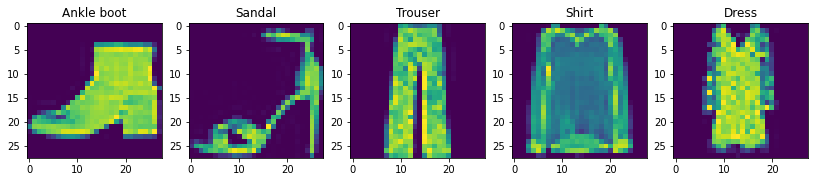

In [10]:
# muestra algunos ejemplos
print(train_loader.dataset.data.size())
print(train_loader.dataset.classes)
n_items = train_loader.dataset.data.size()[0]
random_items = np.random.choice(np.arange(n_items), 5)

plt.figure(figsize=(14,5))
for i in range(5):
    plt.subplot(1,5,i+1)
    item  = random_items[i]
    plt.imshow(train_loader.dataset.data[item])
    plt.title(train_loader.dataset.classes[train_loader.dataset.targets[item]] )

In [12]:
# Selecciona y normaliza 600 para entrenar
train  = train_loader.dataset.data[:600].float()
test = train_loader.dataset.data[-600:].float()
target = train_loader.dataset.targets[:600].float()
y_test = train_loader.dataset.targets[-600:].float()

mean = train.mean(dim=0)
std = train.std(dim=0)
std[std==0]=1.0

for i in range(len(train)):
    train[i] = (train[i]-mean)/std
    test[i] = (test[i]-mean)/std
print(np.shape(train))
print(np.shape(test))

torch.Size([600, 28, 28])
torch.Size([600, 28, 28])


In [13]:
x_train = train.unsqueeze(1)
x_test = test.unsqueeze(1)
y_train = target
print(y_train.size())
print(x_train.size())

n = torch.nn.Conv2d(1, 4, 2, stride=1) # in-channels = 1, out-channels = 4, kernel=4
new_tensor = n(x_train)
print(new_tensor.size())

n = torch.nn.MaxPool2d(kernel_size=3)
new_tensor = n(new_tensor)
print(new_tensor.size())

n = torch.nn.Conv2d(4, 1, 2, stride=1) # in-channels = 4, out-channels = 1, kernel=4
new_tensor = n(new_tensor)
print(new_tensor.size())

n = torch.nn.Flatten()
new_tensor = n(new_tensor)
print(new_tensor.size())

n = torch.nn.Linear(64,10)
new_tensor = n(new_tensor)
print(new_tensor.size())

torch.Size([600])
torch.Size([600, 1, 28, 28])
torch.Size([600, 4, 27, 27])
torch.Size([600, 4, 9, 9])
torch.Size([600, 1, 8, 8])
torch.Size([600, 64])


In [17]:
model = torch.nn.Sequential(
    torch.nn.Conv2d(1, 4, 2, stride=1),
    torch.nn.MaxPool2d(kernel_size=3),
    torch.nn.Conv2d(4, 1, 2, stride=1),
    torch.nn.Flatten(),
    torch.nn.Linear(64,10)
)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05) #lr: learning rate
epochs = 80
loss_values = np.zeros(epochs)
F1_values_train = np.zeros(epochs)
F1_values_test = np.zeros(epochs)


for epoch in range(epochs):
    inputs = torch.autograd.Variable(x_train)
    targets = torch.autograd.Variable(torch.Tensor(y_train).long())
    
    optimizer.zero_grad()
    out = model(inputs)
    out = out.squeeze(dim=1) # necesario para quitar la dimension intermedia de channel
    loss = criterion(out, targets)
    loss.backward()
    optimizer.step()
    
    values, Y_predicted = torch.max(out.data, 1)
    loss_values[epoch] = loss.item()
    F1_values_train[epoch] = sklearn.metrics.f1_score(y_train, Y_predicted, average='macro')
    
    inputs_test = torch.autograd.Variable(x_test)
    out_test = model(inputs_test)
    out_test = out_test.squeeze(dim=1)
    values, Y_predicted_test = torch.max(out_test.data, 1)
    F1_values_test[epoch] = sklearn.metrics.f1_score(y_test, Y_predicted_test, average='macro')

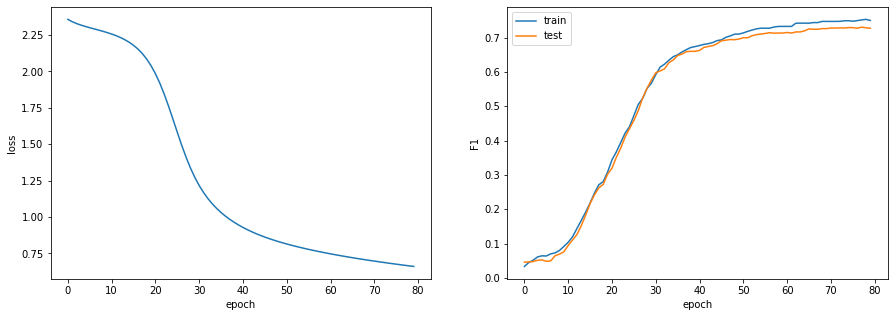

In [18]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(epochs), loss_values)
plt.xlabel('epoch')
plt.ylabel('loss')

plt.subplot(1,2,2)
plt.plot(np.arange(epochs), F1_values_train, label='train')
plt.plot(np.arange(epochs), F1_values_test, label='test')
plt.xlabel('epoch')
plt.ylabel('F1')
plt.legend()